# General analysis - based on gpt model

In [ ]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
 
# Just fill this with wherever is your main data folder is (copy the path just before 'MovieSummaries'):
# file_source = '/Volumes/LaCie/ADA/2024/Projet/'
file_source = 'D:\EPFL\MA3\Applied Data Analysis\Project\MovieSummaries'
#"/Users/Mathieu/Documents/Docs epfl/Semester3/Advanced Data Analysis (ADA)/Test VSCode/ada-2024-project-theadavengers 2/"

# Same goes for the reviews dataset : but simply copy the entire path of where your reviews data is... 
# reviews_path = '/Users/shrinidhivelan/Downloads/TMDB_movie_dataset_v11.csv'
reviews_path = 'D:\EPFL\MA3\Applied Data Analysis\Project\MovieSummaries\TMDB_movie_dataset_v11.csv'
#"/Users/Mathieu/Downloads/reviews dataset/TMDB_movie_dataset_v11.csv"

# replace the following by the direct path of where  [(2) bechdel test dataset] your bechdel test movie data is:
# bechdel_path = '/Users/shrinidhivelan/Desktop/DATA ADA Projet/movies.csv'#'/Users/shrinidhivelan/Downloads/movies.csv'
#"/Users/Mathieu/Downloads/movies.csv"

# replace the following by the direct path of where  [(1) feminism dataset] your bechdel test movie data is:
# bechdel_path2 = "/Users/shrinidhivelan/Desktop/DATA ADA Projet/(1) Feminism/movies.csv"

### creating dataset by extracting the main CMU data ###
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_Movie = create_datasets(file_source, reviews_path)

reviews = pd.read_csv(reviews_path)

MovieMetadata_df['Country dictionnaire'] = MovieMetadata_df['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Genre dictionnaire'] = MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)
MovieMetadata_df['Language dictionnaire'] = MovieMetadata_df['Movie languages (Freebase ID:name tuples)'].apply(ast.literal_eval)


### Merge the movie summaries with movie names 

movie_names_summaries_df = pd.merge(plot_summaries_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')
movie_names_character_df = pd.merge(CharacterMetadata_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')


# ### Bechdel data - the scores of the bechdel tests
# bechdel_2= pd.read_csv(bechdel_path2)
# Movie_data_bechdel_notation_df = pd.merge(MovieMetadata_df, bechdel_2[["title", "year", "bt_score"]], left_on="Movie name", right_on="title", how="inner")


# ### Data to do labels for model (using texts):
# summaries_bechdel_movies_df = pd.merge(plot_summaries_df, Movie_data_bechdel_notation_df, on='Wikipedia movie ID', how='inner')
# summaries_label = summaries_bechdel_movies_df[['Summaries', 'Movie name', 'bt_score']]


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/LaCie/ADA/2024/Projet//MovieSummaries/movie.metadata.tsv'

## For reusability of the model

In [ ]:
from gpt_model import *
from transformers import GPT2Tokenizer, GPT2Model
import torch
import torch.nn as nn
from datasets import Dataset


# Load the pre-trained GPT2 model
gpt_model = GPT2Model.from_pretrained('gpt2')

# Load the GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT2 does not have a pad token by default

# Define the number of classes (assuming binary classification)
num_classes = 2  
model = GPTClassifier(gpt_model, num_classes)

# Load the saved model weights - as this could avoid training the model again
model.load_state_dict(torch.load('best_model_state.bin'))
model.eval()  # Set the model to evaluation mode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_70906/4162976974.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

GPTClassifier(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
)

In [ ]:
def predict_text(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        label = 1 if preds.item() == 1 else 0
    return label

# Trial
sample_text = 'Conflict and Conquest: Central to a feminine plot is a clear conflict, often framed as a battle or competition. The hero may confront external forces (like friends, societal expectations, or natural obstacles) or internal strength (like personal flaws or emotional growth).'
print(f"Message: {sample_text}")
print(f"Prediction: {predict_text(sample_text)}")

Message: Conflict and Conquest: Central to a feminine plot is a clear conflict, often framed as a battle or competition. The hero may confront external forces (like friends, societal expectations, or natural obstacles) or internal strength (like personal flaws or emotional growth).
Prediction: 0


## Load the csv file

In [6]:
import pandas as pd

# Load the dataset
# movie_dataset = pd.read_csv('movies_gpt2_prediction.csv')
movie_dataset = pd.read_csv('C:/Users/jacqu/OneDrive/Documents/ada-2024-project-theadavengers/Prediction csv files/movies_gpt2_prediction.csv')

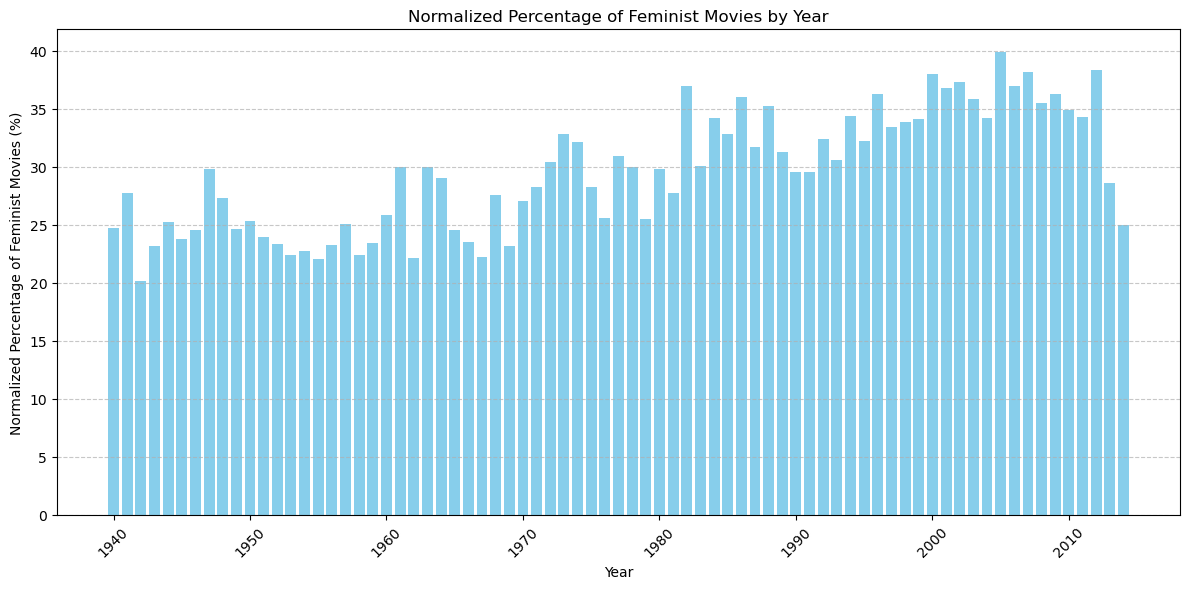

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = movie_dataset.copy()
df = df[df['Year']>=1940]

# Group by year and calculate the total number of movies and the number of feminist movies
yearly_counts = df.groupby('Year')['feminism'].agg(
    total_movies='count',
    feminist_movies=lambda x: x.sum()
)

# Normalize by the total number of movies in each year
yearly_counts['normalized_feminist_percentage'] = (yearly_counts['feminist_movies'] / yearly_counts['total_movies']) * 100

# Plot the results as a bar plot
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index, yearly_counts['normalized_feminist_percentage'], color='skyblue')
plt.title('Normalized Percentage of Feminist Movies by Year')
plt.xlabel('Year')
plt.ylabel('Normalized Percentage of Feminist Movies (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df = movie_dataset.copy()
# Predict on all movies
new_predictions = df['feminism'].values

# Convert predictions to boolean values (True for feminist movie, False otherwise)
bool_new_predictions = [True if prediction == 1 else False for prediction in new_predictions]

# Add the predictions as a new column to the dataframe
movie_names_summaries_df['prediction'] = bool_new_predictions

# Count the total number of movies per year
count_per_year_all = movie_names_summaries_df.groupby('Year').size().reset_index(name='total_movies')

# Count the number of feminist movies per year
feminist_count = movie_names_summaries_df[movie_names_summaries_df['prediction'] == True]
count_per_year_feminist = feminist_count.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_feminist, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the overall number of movies
plt.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
plt.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

# Labeling
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Total and Feminist Movies per Year')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        plt.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


NameError: name 'movie_names_summaries_df' is not defined

### Topic detection

In [16]:
import spacy
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import spacy.lang.en.stop_words as stop_words

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# STOPWORDS from spacy
STOPWORDS = stop_words.STOP_WORDS

import pandas as pd

feminism_summaries_df = df[df['feminism']==1]

# Preprocess the summaries
processed_docs = list()
for doc in nlp.pipe(feminism_summaries_df['Summaries'], n_process=5, batch_size=10):
    # Named entities
    ents = doc.ents  # Named entities
    
    # Lemmatize tokens, remove punctuation and stopwords
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    
    # Remove stopwords and short words
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
    
    # Add named entities to the document
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
    
    processed_docs.append(doc)

# Add bigrams to the processed documents
bigram = Phrases(processed_docs, min_count=15)
for idx in range(len(processed_docs)):
    for token in bigram[processed_docs[idx]]:
        if '_' in token:  # Token is a bigram
            processed_docs[idx].append(token)

# Create a Dictionary representation of the documents
dictionary = Dictionary(processed_docs)

# Filter out rare and frequent words
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Create a Bag-of-Words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train the LDA model
params = {'passes': 10, 'random_state': 42}
model = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=4,
                     passes=params['passes'], random_state=params['random_state'])

# Display the topics
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)

/Users/shrinidhivelan/miniconda3/envs/ada/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


(0, '0.012*"love" + 0.008*"father" + 0.007*"find" + 0.007*"girl" + 0.007*"tell"')
(1, '0.009*"find" + 0.007*"tell" + 0.006*"house" + 0.006*"kill" + 0.005*"girl"')
(2, '0.008*"find" + 0.007*"tell" + 0.007*"Anna" + 0.007*"child" + 0.005*"father"')
(3, '0.010*"find" + 0.010*"kill" + 0.006*"house" + 0.006*"leave" + 0.006*"tell"')
(4, '0.009*"tell" + 0.009*"love" + 0.008*"Mary" + 0.007*"leave" + 0.006*"friend"')
(5, '0.007*"leave" + 0.006*"tell" + 0.006*"find" + 0.005*"Kate" + 0.005*"Paul"')
(6, '0.011*"life" + 0.010*"family" + 0.009*"film" + 0.009*"love" + 0.008*"young"')
(7, '0.009*"film" + 0.006*"leave" + 0.006*"find" + 0.005*"tell" + 0.005*"woman"')
(8, '0.006*"school" + 0.005*"mother" + 0.005*"father" + 0.004*"team" + 0.004*"Julie"')
(9, '0.010*"find" + 0.008*"tell" + 0.006*"leave" + 0.006*"Jane" + 0.004*"try"')


In [17]:
# Train the LDA model
params = {'passes': 10, 'random_state': 42}
model = LdaMulticore(corpus=corpus, num_topics=2, id2word=dictionary, workers=4,
                     passes=params['passes'], random_state=params['random_state'])

# Display the topics
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.008*"love" + 0.006*"life" + 0.006*"family" + 0.006*"find" + 0.005*"father"')
(1, '0.008*"find" + 0.006*"tell" + 0.006*"leave" + 0.005*"kill" + 0.005*"house"')


In [18]:
# plot topics
import pyLDAvis.gensim_models

data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)